# Stress test gpu-memleak-trace trace

In this experiment, we perform the following actions:
- Create a Python script that spams malloc/free events on the GPU server
- Run gpu-memleak-trace to capture those events
- Check and analyze the tool’s performance when handling high-throughput data (using script/pid_monitor_csv.py to export metrics of the trace process PID)

## Envinroment

```sh
root@gpu1 ~/g/script (dev)# ./basic-info.sh 
==============================
 🖥️  System & Kernel Info
==============================
Linux 6.11.0-26-generic #26~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Apr 17 19:20:47 UTC 2 x86_64 x86_64 x86_64 GNU/Linux

Operating System: Ubuntu 24.04.2 LTS
          Kernel: Linux 6.11.0-26-generic
    Architecture: x86-64
 Hardware Vendor: ASUSTeK COMPUTER INC.
  Hardware Model: ROG STRIX X570-F GAMING
Firmware Version: 5031
   Firmware Date: Mon 2025-01-13
    Firmware Age: 7month 4w

==============================
 📦 Distribution Info
==============================
PRETTY_NAME="Ubuntu 24.04.2 LTS"
NAME="Ubuntu"
VERSION_ID="24.04"
VERSION="24.04.2 LTS (Noble Numbat)"
VERSION_CODENAME=noble
ID=ubuntu
ID_LIKE=debian
UBUNTU_CODENAME=noble

==============================
 💾 Hardware Info
==============================
Architecture:                         x86_64
CPU(s):                               32
On-line CPU(s) list:                  0-31
Model name:                           AMD Ryzen 9 5950X 16-Core Processor
BIOS Model name:                      AMD Ryzen 9 5950X 16-Core Processor             Unknown CPU @ 3.4GHz
Thread(s) per core:                   2
Socket(s):                            1
CPU(s) scaling MHz:                   28%
NUMA node0 CPU(s):                    0-31

               total        used        free      shared  buff/cache   available
Mem:           125Gi        78Gi        47Gi        25Mi       2.2Gi        47Gi
Swap:           27Gi        20Gi       7.5Gi

Filesystem                                        Size  Used Avail Use% Mounted on
total                                              93T  1.6T   92T   2% -

==============================
 🎮 GPU Info
==============================
[NVIDIA GPUs detected]
GPU 0: NVIDIA GeForce RTX 5090 (UUID: GPU-47def375-4603-e5fa-82d3-c7cddc81e65a)

0, NVIDIA GeForce RTX 5090, 570.133.07, 32607, 4492, 27620, 0
```

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Run spammer

**In this case, we generate event 4000 events (malloc/free), each event allocate 2048 bytes in 60 seconds**

```sh
python gpu_spammer.py --events-per-sec 4000 --alloc-size 2048 --duration 60

[+] Running 60.0s on cuda:0, 4000.0 events/sec, 2048 bytes per alloc, hold=0.0s
[+] Finished 240001 malloc/free events

```

## Run monitor

Monitor CPU, Memory, DISK I/O by per PID and then export sample as CSV format
```sh
python pid_mon.py --pids <PID> --interval 0.2 --output=../sample/spammer.csv

2025-09-11 16:42:32,2746692,gpu-memleak-trace,0.0,89.1,0.1,50.9,0.0
2025-09-11 16:42:32,2746692,gpu-memleak-trace,0.0,89.1,0.1,50.9,0.0
2025-09-11 16:42:32,2746692,gpu-memleak-trace,0.0,89.1,0.1,50.9,0.0
2025-09-11 16:42:33,2746692,gpu-memleak-trace,0.0,89.1,0.1,50.9,0.0
2025-09-11 16:42:33,2746692,gpu-memleak-trace,0.0,89.1,0.1,50.9,0.0
2025-09-11 16:42:33,2746692,gpu-memleak-trace,0.0,89.1,0.1,50.9,0.0
2025-09-11 16:42:33,2746692,gpu-memleak-trace,0.0,89.1,0.1,50.9,0.0
```

## Process sample

In [24]:
df = pd.read_csv('../sample/spammer.csv')
df.head()

,timestamp,pid,name,cpu_percent,memory_mb,memory_percent,disk_read_kb,disk_write_kb
0,2025-09-11 16:40:36,2746692,gpu-memleak-trace,0.0,79.4,0.1,50.9,0.0
1,2025-09-11 16:40:36,2746692,gpu-memleak-trace,0.0,79.4,0.1,50.9,0.0
2,2025-09-11 16:40:36,2746692,gpu-memleak-trace,0.0,79.4,0.1,50.9,0.0
3,2025-09-11 16:40:36,2746692,gpu-memleak-trace,0.0,79.4,0.1,50.9,0.0
4,2025-09-11 16:40:36,2746692,gpu-memleak-trace,0.0,79.4,0.1,50.9,0.0


In [25]:
def plot_timeseries(df, group, ylabel):
    fig, ax = plt.subplots(figsize=(20, 6))

    # group by chosen column
    for key, grp in df.groupby(group):
        ax.plot(grp['timestamp'], grp[ylabel], label=key)

    # labels and title
    ax.set_xlabel('Timestamp')
    ax.set_ylabel(ylabel.replace('_', ' ').title())
    ax.set_title(
        f'{ylabel.replace("_", " ").title()} Over Time by {group.title()}')

    # legend
    ax.legend(title=group.title())

    # formatting
    plt.tight_layout()
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.xaxis.set_major_formatter(
        plt.FuncFormatter(
            lambda x, pos: df['timestamp'].iloc[int(x)]
            if 0 <= int(x) < len(df['timestamp']) else ''
        )
    )

    plt.show()

### Metrics report

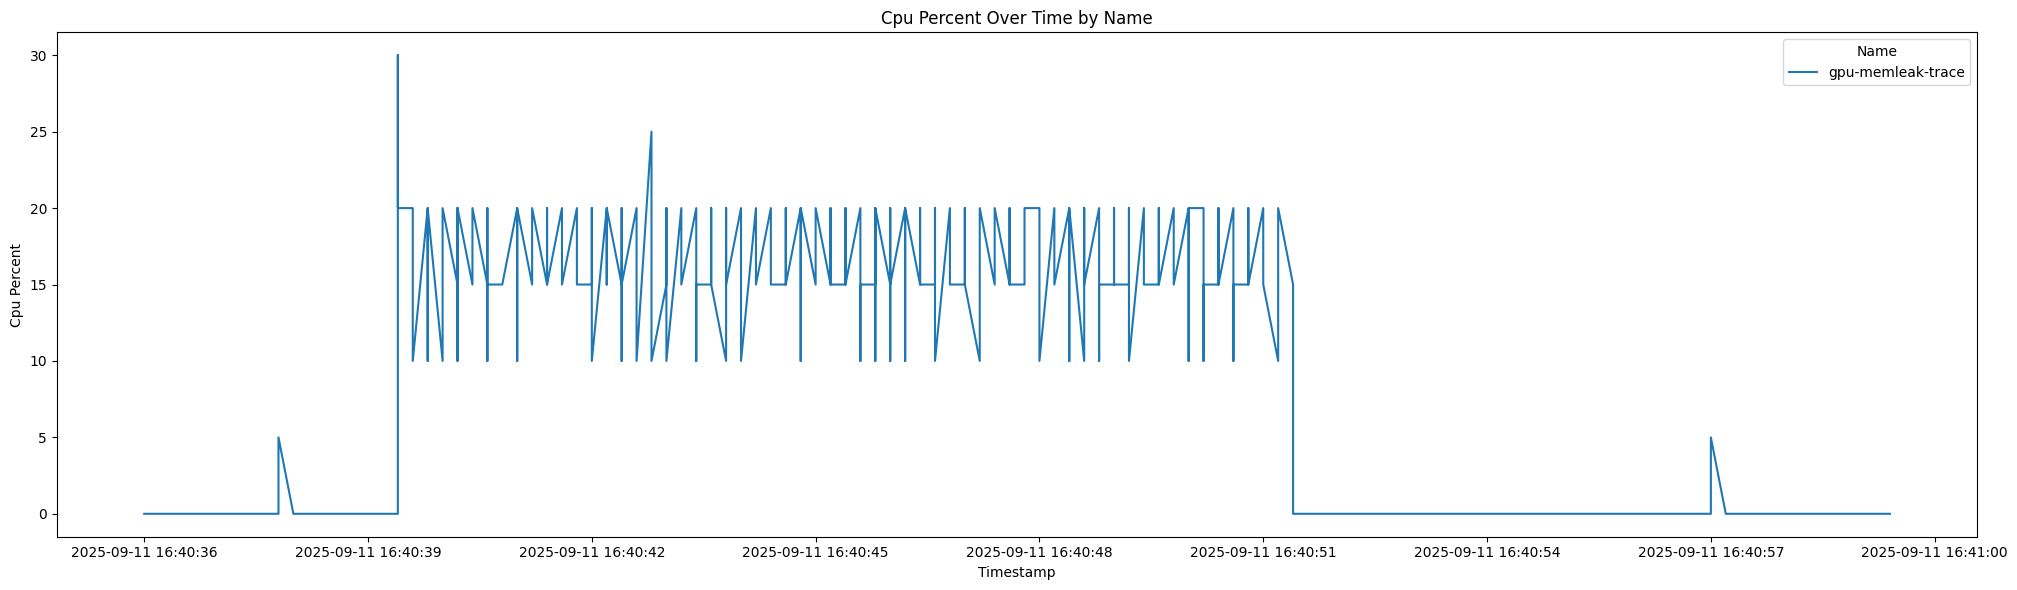

In [26]:
plot_timeseries(df, 'name', 'cpu_percent')

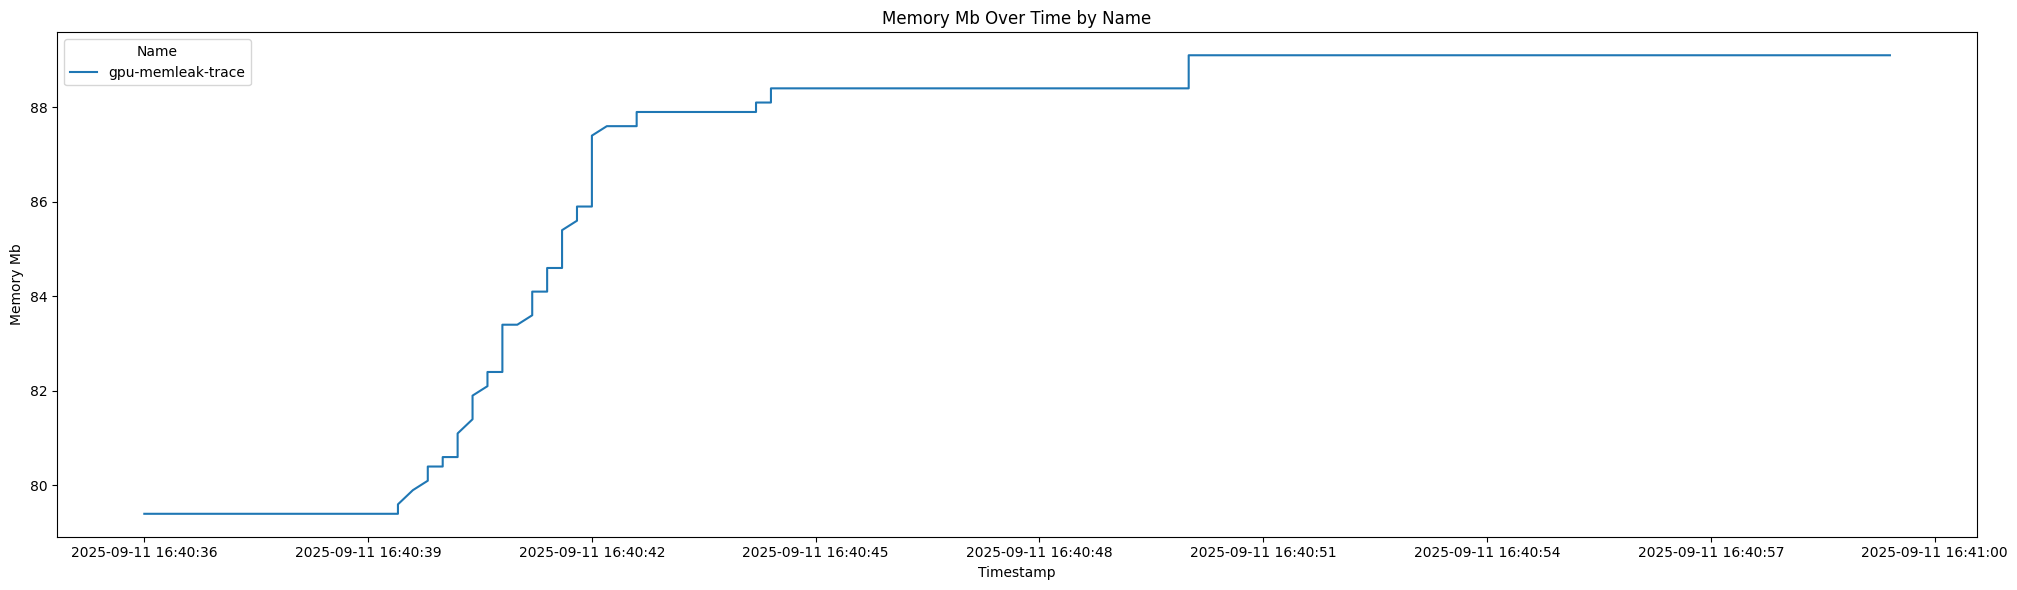

In [27]:
plot_timeseries(df, 'name', 'memory_mb')
